In [1]:
# import os
from pathlib import Path

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from data import HourlyData

# import time

# from hourly_test_utils import *
from applied_data_science.bigquery.data import Meter_Data
from eemeter import eemeter as em
# from eemeter.common.metrics import BaselineTestingMetrics as Metrics

# import multiprocessing as mp

import warnings
warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2

In [2]:
#load subsamples from the main MCE dataset
dataset = 'mce'
subsample = 5
has_solar = True

cache_dir = Path("/app/.recurve_cache/data").resolve()

if 'data' in globals():
    del data

data = Meter_Data(dataset, subsample, "hourly", solar=has_solar, cache_dir=cache_dir)
meta = data.df['meta']
subsample_df = data.df['meter']
ids = subsample_df.index.unique()

Loading: /app/.recurve_cache/data/MCE/MCE_covid_solar_meta_5.pkl
Done in 0.003 s
Loading: /app/.recurve_cache/data/MCE/MCE_covid_solar_hourly_meter_5.pkl
Done in 2.233 s


In [3]:
alpha_opt = 0.15
l1_ratio_opt = 0.05
settings = em.HourlySettings(
    TRAIN_FEATURES=['ghi'],
    LAGGED_FEATURES=None, # 'ghi'
    WINDOW=None,
    SUPPLEMENTAL_DATA=None,
    # SUPPLEMENTAL_DATA=['solar_supp'],
    ALPHA=alpha_opt,
    L1_RATIO=l1_ratio_opt,
    SELECTION="cyclic",
    MAX_ITER=1000,
    SEED=42
)



In [4]:
# get one meter
meter_id = ids[40]
meter = subsample_df.loc[meter_id].copy()
PV_interventation = "2019-11-09"
#change PV_interventation to datetime
PV_interventation = pd.to_datetime(PV_interventation)
meter['solar_supp'] = 0
meter.loc[meter['date'] >= PV_interventation.date(), 'solar_supp'] = 1

# select baseline period
meter_baseline = meter.loc[meter['period'] == 'baseline'].copy()

meta_meter = meta.loc[meter_id]

# get unique pair of station_latitude and station_longitude
unique_pairs = meta_meter[['station_latitude', 'station_longitude']].drop_duplicates()

# print unique pairs
METADATA = {
    'station_latitude': unique_pairs['station_latitude'].values[0],
    'station_longitude': unique_pairs['station_longitude'].values[0],
}

#TODO: keep it simple and let the input force the output
OUTPUT_FEATURES=['temperature', 'observed', 'model', 'solar_supp']
if 'ghi' in settings.TRAIN_FEATURES:
    CONSIDER_SOLAR = True
    OUTPUT_FEATURES.append('ghi')
    OUTPUT_FEATURES.append('clearsky_ghi')
else:
    CONSIDER_SOLAR = False
kwargs = {
    'solar': CONSIDER_SOLAR,
    'metadata': METADATA,
    'outputs': OUTPUT_FEATURES,
}
data_baseline = HourlyData(meter_baseline, **kwargs)

In [5]:
model = em.HourlyModel(settings)
model.fit(data_baseline)
pred_baseline = model.predict(data_baseline)


In [6]:
pred_baseline

,temperature,observed,model,solar_supp,ghi,clearsky_ghi,interpolated,predicted
datetime,,,,,,,,
2019-03-02 00:00:00,52.76180,1.2566,1.154066,0.0,0.0,0.0,False,1.066887
2019-03-02 01:00:00,51.43775,1.2030,1.099054,0.0,0.0,0.0,False,1.002854
2019-03-02 02:00:00,51.08000,1.1980,1.018050,0.0,0.0,0.0,False,0.889589
2019-03-02 03:00:00,51.08000,1.2036,0.875144,0.0,0.0,0.0,False,0.731127
2019-03-02 04:00:00,51.07078,1.2050,0.544285,0.0,0.0,0.0,False,0.585172
...,...,...,...,...,...,...,...,...
2020-02-29 19:00:00,53.06000,0.2967,0.653152,1.0,0.0,NaN,True,NaN
2020-02-29 20:00:00,53.04845,0.4982,0.803996,1.0,0.0,NaN,True,NaN
2020-02-29 21:00:00,51.86075,0.4198,0.536352,1.0,0.0,NaN,True,NaN


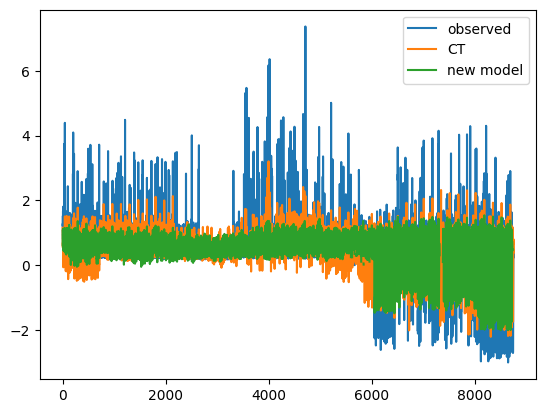

In [7]:
s = 0
w = -1
e = s + w
plt.plot(pred_baseline['observed'].iloc[s:e].values, label='observed')
plt.plot(pred_baseline['model'].iloc[s:e].values, label='CT')
plt.plot(pred_baseline['predicted'].iloc[s:e].values, label='new model')
# plt.plot(-pred_baseline['ghi'].iloc[s:e].values*3, label='ghi')
plt.legend()
plt.show()

In [8]:
meter_reporting = meter.loc[meter['period'] == 'reporting'].copy()
data_reporting = HourlyData(meter_reporting, **kwargs)
reporting_pred = model.predict(data_reporting)
reporting_pred

,temperature,observed,model,solar_supp,ghi,clearsky_ghi,interpolated,predicted
datetime,,,,,,,,
2020-03-01 00:00:00,49.34405,1.171300,0.514831,1.0,0.0,0.0,False,0.878539
2020-03-01 01:00:00,48.37145,1.210300,0.503239,1.0,0.0,0.0,False,0.826129
2020-03-01 02:00:00,47.37560,1.206400,0.523200,1.0,0.0,0.0,False,0.801701
2020-03-01 03:00:00,47.59070,1.208300,0.420685,1.0,0.0,0.0,False,0.821457
2020-03-01 04:00:00,48.01370,1.209500,0.388921,1.0,0.0,0.0,False,0.652672
...,...,...,...,...,...,...,...,...
2021-03-31 19:00:00,75.01400,0.588300,0.376273,1.0,0.0,0.0,False,0.625420
2021-03-31 20:00:00,69.97400,0.512399,0.175235,1.0,0.0,0.0,False,0.553539
2021-03-31 21:00:00,64.95185,0.501000,0.278110,1.0,0.0,0.0,False,0.559659


In [9]:
# pred['temperature'].quantile(0.95)
# find days with temperature above 95th percentile
hot_hours = reporting_pred[reporting_pred['temperature'] > reporting_pred['temperature'].quantile(0.995)]
unique_days = np.unique(hot_hours.index.date)
print(unique_days.shape)

reporting_pred['date'] = reporting_pred.index.date
 # get days that are in unique_days
hot_days = reporting_pred[reporting_pred['date'].isin(unique_days)]
hot_days

(12,)


,temperature,observed,model,solar_supp,ghi,clearsky_ghi,interpolated,predicted,date
datetime,,,,,,,,,
2020-05-26 00:00:00,71.54255,0.3090,0.944207,1.0,0.0,0.0,False,1.038983,2020-05-26
2020-05-26 01:00:00,68.77550,0.3105,0.848782,1.0,0.0,0.0,False,1.011213,2020-05-26
2020-05-26 02:00:00,66.79550,0.2918,0.785215,1.0,0.0,0.0,False,0.959066,2020-05-26
2020-05-26 03:00:00,64.82075,0.5497,0.686992,1.0,0.0,0.0,False,0.901727,2020-05-26
2020-05-26 04:00:00,63.38405,0.5628,0.508576,1.0,0.0,0.0,False,0.708695,2020-05-26
...,...,...,...,...,...,...,...,...,...
2020-09-07 19:00:00,98.17325,2.9261,1.994557,1.0,0.0,0.0,False,0.944910,2020-09-07
2020-09-07 20:00:00,94.57100,0.6100,1.700613,1.0,0.0,0.0,False,0.809475,2020-09-07
2020-09-07 21:00:00,90.60995,1.1222,1.316160,1.0,0.0,0.0,False,0.917033,2020-09-07


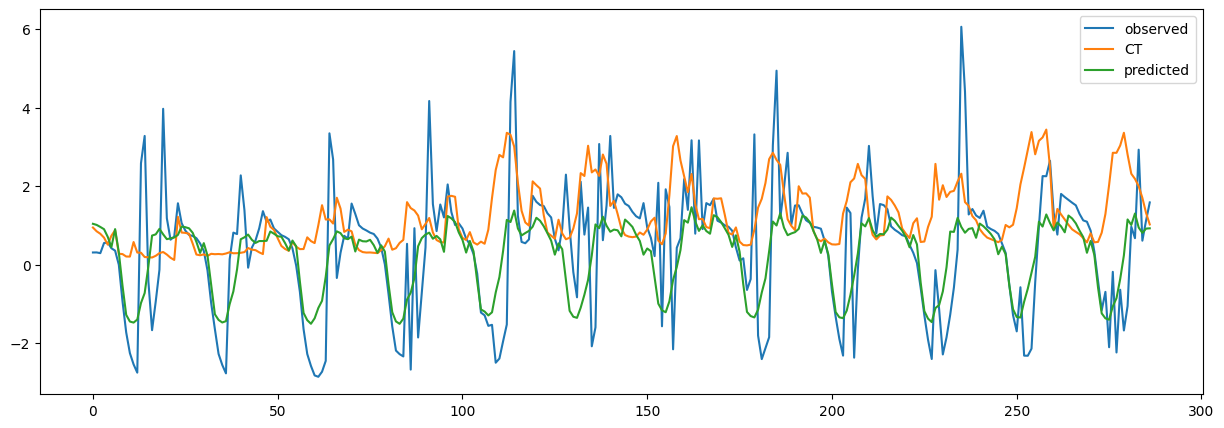

In [10]:
plt.rcParams['figure.figsize'] = [15, 5]
s = 24*0
w = -1
e = s + w
plt.plot(hot_days['observed'].iloc[s:e].values, label='observed')
plt.plot(hot_days['model'].iloc[s:e].values, label='CT')
plt.plot(hot_days['predicted'].iloc[s:e].values, label='predicted')
plt.legend()

# plt.plot(-hot_days['ghi'].iloc[s:e].values*7, label='ghi')

plt.show()

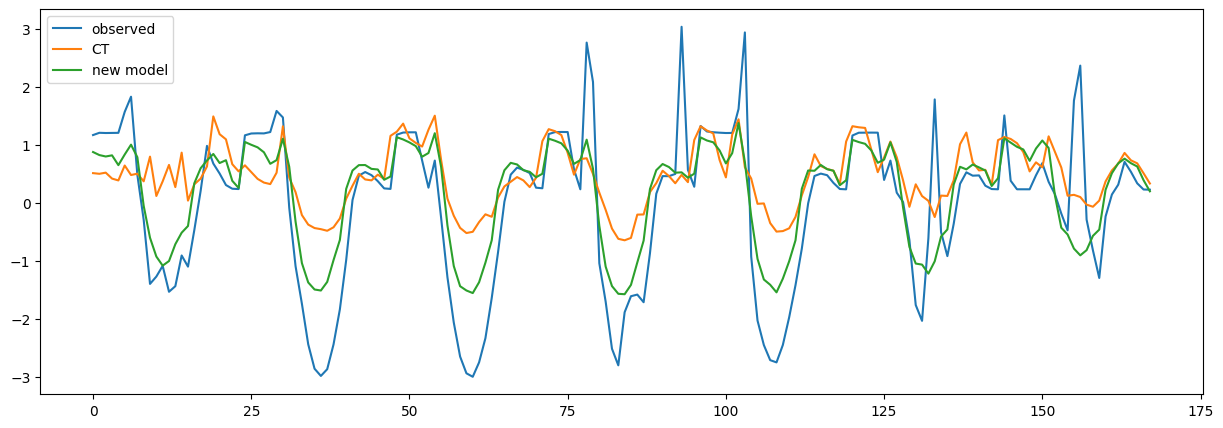

In [11]:
s = 24*0
w = 24*7
e = s + w
plt.plot(reporting_pred['observed'].iloc[s:e].values, label='observed')
plt.plot(reporting_pred['model'].iloc[s:e].values, label='CT')
plt.plot(reporting_pred['predicted'].iloc[s:e].values, label='new model')
# plt.plot(-pred_baseline['ghi'].iloc[s:e].values*3, label='ghi')
plt.legend()
plt.show()